In [2]:
import sys  
sys.path.insert(1, '/Users/simon/Documents/II/Dissertation/')
%load_ext autoreload
%autoreload 2
from src.misc import load_processed_dataset, split_data, create_sequences, evaluate
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from src.models.LSTM.model import StockPriceLSTM
import numpy as np
import pandas as pd

https://medium.com/@lucasastorian/understanding-financial-feature-importance-7eeb49c2df0b

# Feature Selection

In [66]:
import os
from src.misc import load_processed_dataset
import pandas as pd

# Market Indices
df = load_processed_dataset("aapl", "2018-01-01", "2023-01-1")
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Close Forecast', 'close_t-1', 'close_t-2', 'close_t-3', 'close_t-4',
       'close_t-5', 'pct_change', 'return', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'upper_band',
       'middle_band', 'lower_band', 'SMA_3', 'SMA_5', 'SMA_10', 'SMA_20',
       'SMA_50', 'EMA_3', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'DEMA_3',
       'DEMA_5', 'DEMA_10', 'DEMA_20', 'DEMA_50', 'TEMA_3', 'TEMA_5',
       'TEMA_10', 'TEMA_20', 'TEMA_50', 'ADX', 'aroon_down', 'aroon_up',
       'macd', 'macdsignal', 'macdhist', 'RSI_14', 'slow_k', 'slow_d',
       'williams_r', 'AD', 'OBV', 'NATR', 'TRANGE', 'fed_funds_rate', '^N225',
       '^IXIC', '^FTSE', '^SPX', '^DJI'],
      dtype='object')

In [67]:
X = df.drop([x for x in df.columns if "Forecast" in x], axis=1)  # Features
y = df['Close Forecast']  # Target variable

## Filter Methods

Correlation Coefficient

<Axes: >

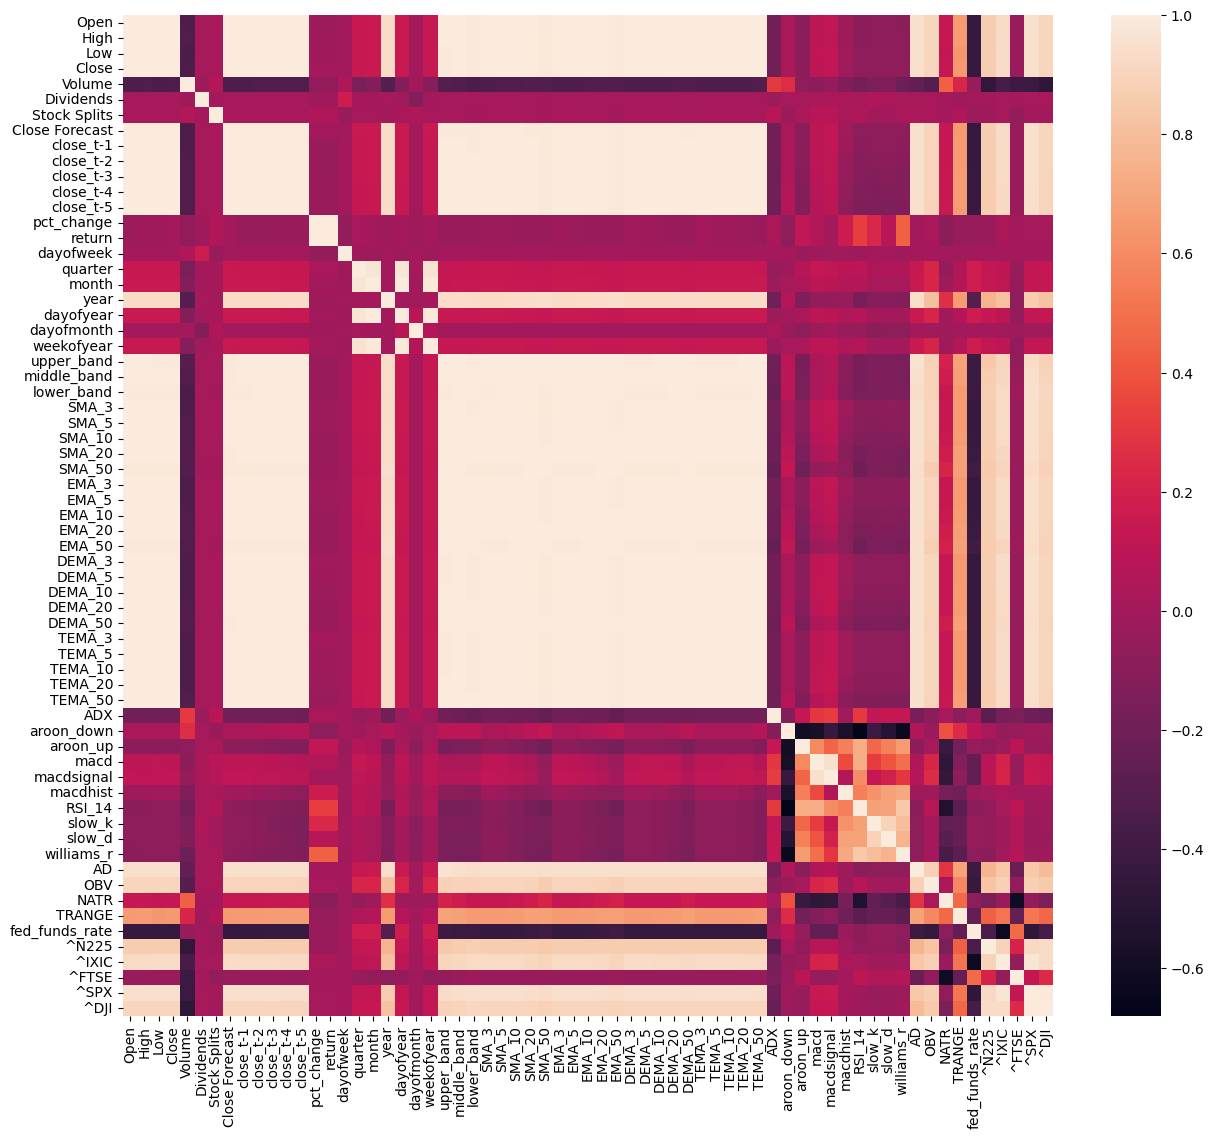

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

plt.figure(figsize=(15, 13))  # Increase figure size
sns.heatmap(correlation_matrix, fmt=".2g")

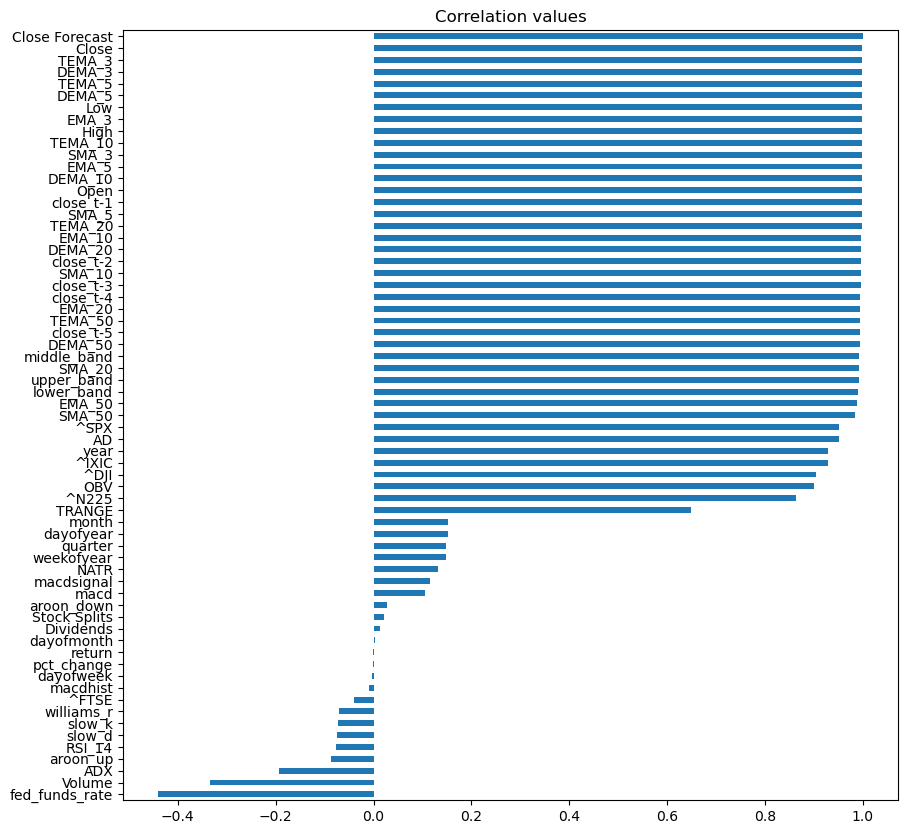

In [71]:
corr_values = correlation_matrix['Close Forecast'].sort_values(ascending=True)
corr_values.plot.barh(figsize=(10, 10))
plt.title('Correlation values')
plt.show()

Mutual Information

In [72]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np

mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=True)  # Sorting the scores

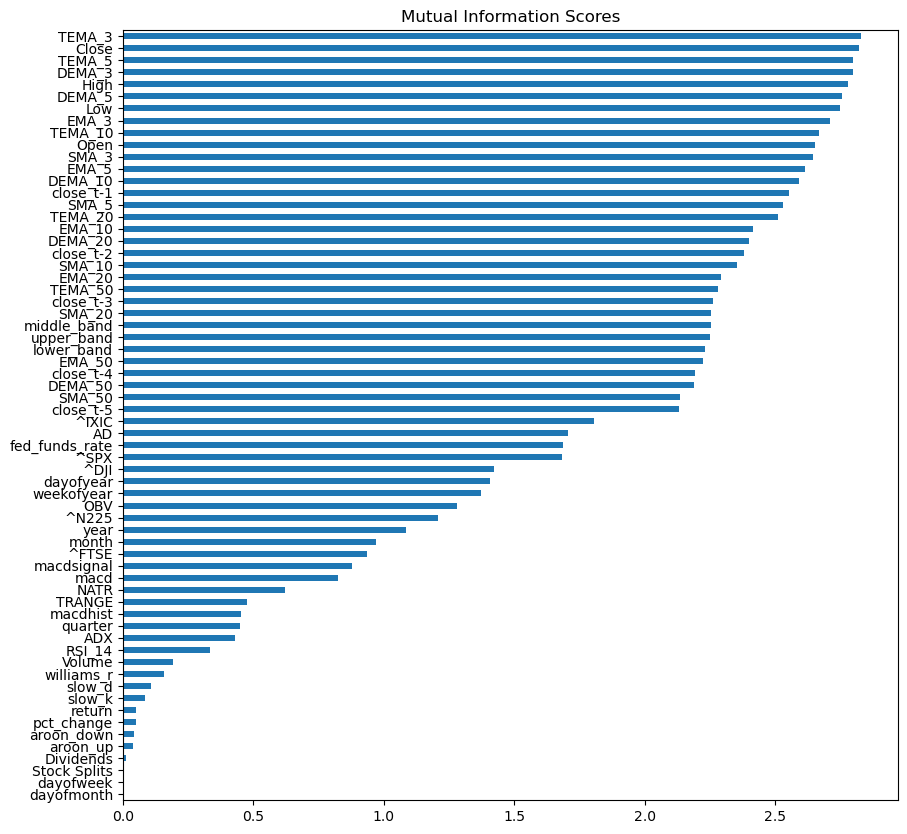

In [86]:
mi_scores.plot.barh(figsize=(10, 10))
plt.title('Mutual Information Scores')
plt.show()

In [84]:
mi_scores_norm = (mi_scores - min(mi_scores)) / (max(mi_scores) - min(mi_scores))
mi_scores_norm

dayofmonth      0.000000
dayofweek       0.000000
Stock Splits    0.000000
Dividends       0.003487
aroon_up        0.012954
                  ...   
High            0.981792
DEMA_3          0.989193
TEMA_5          0.989305
Close           0.997717
TEMA_3          1.000000
Name: MI Scores, Length: 64, dtype: float64

# Model Agnostic Methods

Calculate score for each stock. Combine scores for final score

In [33]:
stocks = ["MSFT", "AAPL", "NVDA", "AMZN", "META", "GOOG", "BRK-B", "LLY", "AVGO", "TSLA", "JPM", "UNH", "V", "XOM", "JNJ", "MA", "PG", "HD", "MRK", "COST"]

In [3]:
from src.misc import load_processed_dataset, split_data, create_sequences, evaluate
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from src.models.LSTM.model import StockPriceLSTM
import numpy as np
import pandas as pd

sequence_len = 5
batch_size = 256
hidden_dim = 64
num_layers = 2
num_epochs = 10

all_feature_scores = pd.DataFrame()
for s in stocks:
    df = load_processed_dataset(s)
    X = df.drop("Close Forecast", axis=1)
    y = df["Close Forecast"]
    
    features = X.columns
    feature_scores = []
    for f in features:
        X_f = pd.DataFrame(X[f])
        # Split
        X_train, X_val, X_test = split_data(X_f, verbose=False)
        y_train, y_val, y_test = split_data(y, verbose=False)

         # Normalisation
        in_scaler = StandardScaler()
        out_scaler = StandardScaler()
        X_train_norm = in_scaler.fit_transform(X_train.values)
        X_val_norm = in_scaler.transform(X_val.values)
        X_test_norm = in_scaler.transform(X_test.values)
        y_train_norm = out_scaler.fit_transform(y_train.values.reshape(-1, 1))
        y_val_norm = out_scaler.transform(y_val.values.reshape(-1, 1))
        y_test_norm = out_scaler.transform(y_test.values.reshape(-1, 1))

        # Sequencing
        X_train_seq, y_train_seq = create_sequences(
            X_train_norm, y_train_norm, sequence_len
        )
        X_val_seq, y_val_seq = create_sequences(X_val_norm, y_val_norm, sequence_len)
        X_test_seq, y_test_seq = create_sequences(X_test_norm, y_test_norm, sequence_len)

        # TensorDatasets and DataLoaders
        train_dataset = TensorDataset(
            torch.tensor(X_train_seq.astype(np.float32)),
            torch.tensor(y_train_seq.astype(np.float32)),
        )
        val_dataset = TensorDataset(
            torch.tensor(X_val_seq.astype(np.float32)),
            torch.tensor(y_val_seq.astype(np.float32)),
        )
        test_dataset = TensorDataset(
            torch.tensor(X_test_seq.astype(np.float32)),
            torch.tensor(y_test_seq.astype(np.float32)),
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Create model:
        input_dim = 1
        output_dim = 1  # Number of output classes (predicting 'Close Forecast')
        model = StockPriceLSTM(input_dim, hidden_dim, num_layers, output_dim)

        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

         # Train:
        for epoch in range(num_epochs):
            # Training
            model.train()
            train_loss = 0.0
            for Xs, ys in train_loader:
                optimizer.zero_grad()
                outputs = model(Xs)
                loss = criterion(outputs, ys)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss /= Xs.size(0)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            actuals, predictions = [], []
            for Xs, ys in val_loader:
                outputs = model(Xs)
                predictions.extend(outputs.flatten().tolist())
                actuals.extend(ys.flatten().tolist())
                loss = criterion(outputs, ys)
                val_loss += loss.item()
        val_loss /= Xs.size(0)
        predictions = out_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        actuals = out_scaler.inverse_transform(np.array(actuals).reshape(-1, 1))
        r2, mse, rmse, mae, mape = evaluate(predictions, actuals)
        val_performance = {
            "stock": s,
            "feature": f,
            "loss": val_loss,
            "rmse": rmse
        }
        feature_scores.append(val_performance)
    df = pd.DataFrame(feature_scores)
    all_feature_scores = pd.concat([all_feature_scores, df])
    print(df)
avg_metrics = all_feature_scores.groupby("feature")[['loss', 'rmse']].mean()
avg_metrics

KeyboardInterrupt: 

In [29]:
avg_metrics.sort_values(by="rmse")

,loss,rmse
feature,,
SMA_3,0.001826,16.985505
Open,0.001873,17.287123
Low,0.002021,17.527790
Close,0.001771,17.706665
High,0.001756,17.826143
close_t-1,0.001889,18.018246
EMA_3,0.001679,18.144921
EMA_5,0.001950,18.619657
close_t-2,0.001870,18.668336


In [30]:
feature_sets ={
    "all": [
        'SMA_3',
        'Open',
        'Low',
        'Close',
        'High',
        'close_t-1',
        'EMA_3',
        'EMA_5',
        'close_t-2',
        'SMA_5',
        'close_t-3',
        'SMA_10',
        'lower_band',
        'EMA_10',
        'close_t-5',
        'close_t-4',
        'SMA_20',
        'EMA_20',
        'middle_band',
        'upper_band',
        'EMA_50',
        'SMA_50',
        '^SPX',
        '^DJI',
        'OBV',
        'year',
        'AD',
        'TRANGE',
        '^IXIC',
        '^N225',
        'fed_funds_rate',
        'macdhist',
        'ADX',
        'Dividends',
        'dayofmonth',
        'Stock Splits',
        'dayofweek',
        'Volume',
        'slow_k',
        'pct_change',
        'slow_d',
        'return',
        'aroon_down',
        'williams_r',
        'aroon_up',
        'NATR',
        'RSI_14',
        'macd',
        'macdsignal',
        'quarter',
        'dayofyear',
        'weekofyear',
        'month',
        '^FTSE',
    ],

    "base": [
        'Open',
        'Low',
        'Close',
        'High',
        'Volume'
    ],

    "top5": [
        'SMA_3',
        'Open',
        'Low',
        'Close',
        'High',
    ],

    "top10": [
        'SMA_3',
        'Open',
        'Low',
        'Close',
        'High',
        'close_t-1',
        'EMA_3',
        'EMA_5',
        'close_t-2',
        'SMA_5',
    ],

   "top20": [
        'SMA_3',
        'Open',
        'Low',
        'Close',
        'High',
        'close_t-1',
        'EMA_3',
        'EMA_5',
        'close_t-2',
        'SMA_5',
        'close_t-3',
        'SMA_10',
        'lower_band',
        'EMA_10',
        'close_t-5',
        'close_t-4',
        'SMA_20',
        'EMA_20',
        'middle_band',
        'upper_band',
    ],

    "top30":[
        'SMA_3',
        'Open',
        'Low',
        'Close',
        'High',
        'close_t-1',
        'EMA_3',
        'EMA_5',
        'close_t-2',
        'SMA_5',
        'close_t-3',
        'SMA_10',
        'lower_band',
        'EMA_10',
        'close_t-5',
        'close_t-4',
        'SMA_20',
        'EMA_20',
        'middle_band',
        'upper_band',
        'EMA_50',
        'SMA_50',
        '^SPX',
        '^DJI',
        'OBV',
        'year',
        'AD',
        'TRANGE',
        '^IXIC',
        '^N225',
    ],

    "hand_picked":[
        'SMA_3',
        'Open',
        'Low',
        'Close',
        'High',
        'EMA_3',
        'EMA_5',
        'SMA_5',
        'SMA_10',
        'lower_band',
        'EMA_10',
        'SMA_20',
        'EMA_20',
        'middle_band',
        'upper_band',
        'EMA_50',
        'SMA_50',
        '^SPX',
        '^DJI',
        'OBV',
        'williams_r',
        'RSI_14',
    ]
}


In [49]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer

from src.models.LSTM_Lightning.model import StockPricePredictor
from src.models.LSTM_Lightning.data import StockDataModule

np.random.seed(1)   
torch.manual_seed(1)

sequence_len = 10
batch_size = 64
hidden_dim = 64
output_dim = 1
num_layers = 2
num_epochs = 20
lr = 0.001

for name, features in feature_sets.items():
    model = StockPricePredictor(features, sequence_len, len(features), hidden_dim, num_layers, output_dim, lr)
    data_module = StockDataModule("aapl", features, sequence_len, batch_size)
    
    early_stop_callback = EarlyStopping(monitor="val_loss", patience=10, verbose=False, mode="min")
    trainer = Trainer(fast_dev_run=True)
    logger = TensorBoardLogger("tb_logs", name=f"lstm_feature_set_{name}", default_hp_metric=True)

    # trainer = Trainer(overfit_batches=1)
    trainer = Trainer(max_epochs=num_epochs, callbacks=[], logger=logger)
    trainer.fit(model, data_module)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/lstm_feature_set_all

  | Name      | Type             | Params | In sizes    | Out sizes                              
-------------------------------------------------------------------------------------------------------
0 | lstm      | LSTM             | 64.0 K | [1, 10, 54] | [[1, 10, 64], [[2, 1, 64], [2, 1, 64]]]
1 | fc        | Linear           | 65     | [1, 64]     | [1, 1]                                 
2 | criterion | MSELoss          | 0      | ?           | ?                                      
3 | rmse      | MeanSquaredEr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/lstm_feature_set_base

  | Name      | Type             | Params | In sizes   | Out sizes                              
------------------------------------------------------------------------------------------------------
0 | lstm      | LSTM             | 51.5 K | [1, 10, 5] | [[1, 10, 64], [[2, 1, 64], [2, 1, 64]]]
1 | fc        | Linear           | 65     | [1, 64]    | [1, 1]                                 
2 | criterion | MSELoss          | 0      | ?          | ?                        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/lstm_feature_set_top5

  | Name      | Type             | Params | In sizes   | Out sizes                              
------------------------------------------------------------------------------------------------------
0 | lstm      | LSTM             | 51.5 K | [1, 10, 5] | [[1, 10, 64], [[2, 1, 64], [2, 1, 64]]]
1 | fc        | Linear           | 65     | [1, 64]    | [1, 1]                                 
2 | criterion | MSELoss          | 0      | ?          | ?                        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/lstm_feature_set_top10

  | Name      | Type             | Params | In sizes    | Out sizes                              
-------------------------------------------------------------------------------------------------------
0 | lstm      | LSTM             | 52.7 K | [1, 10, 10] | [[1, 10, 64], [[2, 1, 64], [2, 1, 64]]]
1 | fc        | Linear           | 65     | [1, 64]     | [1, 1]                                 
2 | criterion | MSELoss          | 0      | ?           | ?                  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/lstm_feature_set_top20

  | Name      | Type             | Params | In sizes    | Out sizes                              
-------------------------------------------------------------------------------------------------------
0 | lstm      | LSTM             | 55.3 K | [1, 10, 20] | [[1, 10, 64], [[2, 1, 64], [2, 1, 64]]]
1 | fc        | Linear           | 65     | [1, 64]     | [1, 1]                                 
2 | criterion | MSELoss          | 0      | ?           | ?                  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/lstm_feature_set_top30

  | Name      | Type             | Params | In sizes    | Out sizes                              
-------------------------------------------------------------------------------------------------------
0 | lstm      | LSTM             | 57.9 K | [1, 10, 30] | [[1, 10, 64], [[2, 1, 64], [2, 1, 64]]]
1 | fc        | Linear           | 65     | [1, 64]     | [1, 1]                                 
2 | criterion | MSELoss          | 0      | ?           | ?                  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/lstm_feature_set_hand_picked

  | Name      | Type             | Params | In sizes    | Out sizes                              
-------------------------------------------------------------------------------------------------------
0 | lstm      | LSTM             | 55.8 K | [1, 10, 22] | [[1, 10, 64], [[2, 1, 64], [2, 1, 64]]]
1 | fc        | Linear           | 65     | [1, 64]     | [1, 1]                                 
2 | criterion | MSELoss          | 0      | ?           | ?            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


# Permutation Feature Importance

In [7]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'close_t-1', 'close_t-2', 'close_t-3', 'close_t-4',
       'close_t-5', 'pct_change', 'return', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'upper_band',
       'middle_band', 'lower_band', 'SMA_3', 'SMA_5', 'SMA_10', 'SMA_20',
       'SMA_50', 'EMA_3', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'DEMA_3',
       'DEMA_5', 'DEMA_10', 'DEMA_20', 'DEMA_50', 'TEMA_3', 'TEMA_5',
       'TEMA_10', 'TEMA_20', 'TEMA_50', 'ADX', 'aroon_down', 'aroon_up',
       'macd', 'macdsignal', 'macdhist', 'RSI_14', 'slow_k', 'slow_d',
       'williams_r', 'AD', 'OBV', 'NATR', 'TRANGE', 'fed_funds_rate', '^N225',
       '^IXIC', '^FTSE', '^SPX', '^DJI']
len(features)

64

In [5]:
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

from src.models.LSTM_Lightning.model import StockPricePredictor
from src.models.LSTM_Lightning.data import StockDataModule

import pandas as pd

np.random.seed(42)   
torch.manual_seed(42)

sequence_len = 5
batch_size = 128
hidden_dim = 64
output_dim = 1
num_layers = 2
num_epochs = 30
lr = 0.001

model = StockPricePredictor(sequence_len, len(features), hidden_dim, num_layers, output_dim, lr)
data_module = StockDataModule("aapl", features, sequence_len, batch_size)
checkpoint_callback = ModelCheckpoint(dirpath="models/", save_top_k=2, monitor="hp/rmse")
logger = TensorBoardLogger("tb_logs", name=f"lstm_pi_baseline", default_hp_metric=False)
trainer = Trainer(max_epochs=num_epochs, callbacks=[checkpoint_callback], logger=logger, enable_progress_bar=False, enable_model_summary=False)
trainer.fit(model, datamodule=data_module)
best_model_path = checkpoint_callback.best_model_path
base_rmse = trainer.validate(model, datamodule=data_module, ckpt_path=best_model_path)[0]["hp/rmse"]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/simon/Documents/II/Dissertation/notebooks/models exists and is not empty.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve perf

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          hp/rmse          │    14.026993751525879     │
│         val_loss          │    0.12109072506427765    │
└───────────────────────────┴───────────────────────────┘

In [106]:
all_pi_importances = pd.DataFrame()
for s in stocks:
    pi_importances = []
    for f in features:
        permuted_dm = StockDataModule("aapl", features, sequence_len, batch_size, permute_column=f)
        rmse = trainer.validate(model, datamodule=permuted_dm, ckpt_path=best_model_path, verbose=False)[0]["hp/rmse"]
        pi_importances.append({
            "permuted_feature": f,
            "importance":  rmse - base_rmse
        })
    pi_importances = pd.DataFrame(pi_importances)
    all_pi_importances = pd.concat([all_pi_importances, pi_importances])

Restoring states from the checkpoint path at /Users/simon/Documents/II/Dissertation/notebooks/models/epoch=21-step=176-v8.ckpt
Loaded model weights from the checkpoint at /Users/simon/Documents/II/Dissertation/notebooks/models/epoch=21-step=176-v8.ckpt
Restoring states from the checkpoint path at /Users/simon/Documents/II/Dissertation/notebooks/models/epoch=21-step=176-v8.ckpt
Loaded model weights from the checkpoint at /Users/simon/Documents/II/Dissertation/notebooks/models/epoch=21-step=176-v8.ckpt
Restoring states from the checkpoint path at /Users/simon/Documents/II/Dissertation/notebooks/models/epoch=21-step=176-v8.ckpt
Loaded model weights from the checkpoint at /Users/simon/Documents/II/Dissertation/notebooks/models/epoch=21-step=176-v8.ckpt
Restoring states from the checkpoint path at /Users/simon/Documents/II/Dissertation/notebooks/models/epoch=21-step=176-v8.ckpt
Loaded model weights from the checkpoint at /Users/simon/Documents/II/Dissertation/notebooks/models/epoch=21-step=

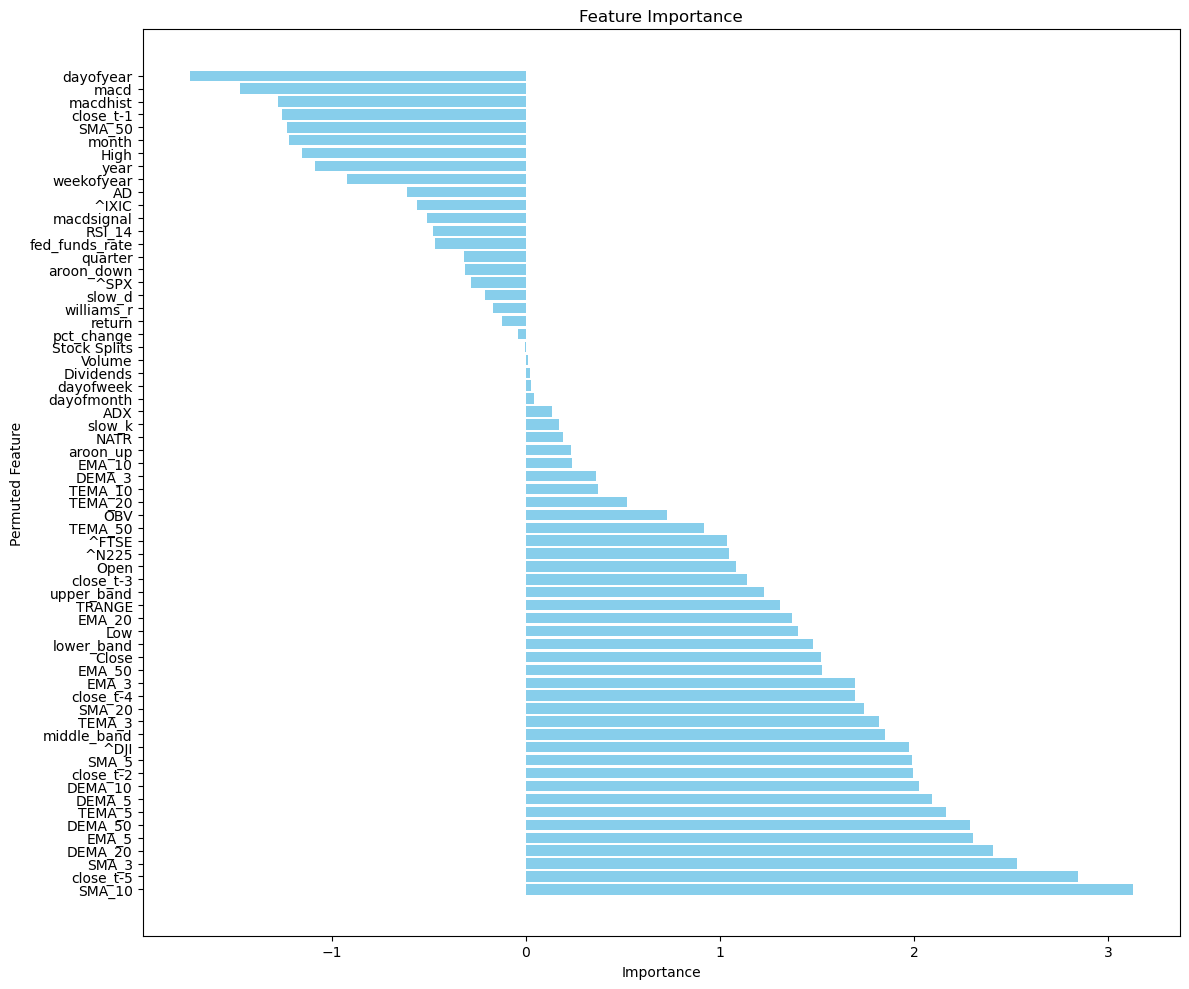

In [113]:
all_pi_importances = all_pi_importances.groupby(by="permuted_feature").mean().sort_values(by="importance", ascending=False).reset_index()
# Plotting
plt.figure(figsize=(12, 10))
plt.barh(all_pi_importances['permuted_feature'], all_pi_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Permuted Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [122]:
all_pi_importances

,permuted_feature,importance
0,SMA_10,3.125776
1,close_t-5,2.842400
2,SMA_3,2.526936
3,DEMA_20,2.405522
4,EMA_5,2.301418
...,...,...
59,SMA_50,-1.229721
60,close_t-1,-1.256097
61,macdhist,-1.276659
62,macd,-1.471432


# Combining MI and PFI

In [131]:
pi_scores = pd.Series(data = all_pi_importances["importance"].values, index=all_pi_importances["permuted_feature"])
pi_scores_norm = (pi_scores - min(pi_scores)) / (max(pi_scores) - min(pi_scores))
pi_scores_norm

permuted_feature
SMA_10       1.000000
close_t-5    0.941650
SMA_3        0.876693
DEMA_20      0.851693
EMA_5        0.830257
               ...   
SMA_50       0.103162
close_t-1    0.097731
macdhist     0.093497
macd         0.053392
dayofyear    0.000000
Length: 64, dtype: float64

In [133]:
mi_scores_norm

dayofmonth      0.000000
dayofweek       0.000000
Stock Splits    0.000000
Dividends       0.003487
aroon_up        0.012954
                  ...   
High            0.981792
DEMA_3          0.989193
TEMA_5          0.989305
Close           0.997717
TEMA_3          1.000000
Name: MI Scores, Length: 64, dtype: float64

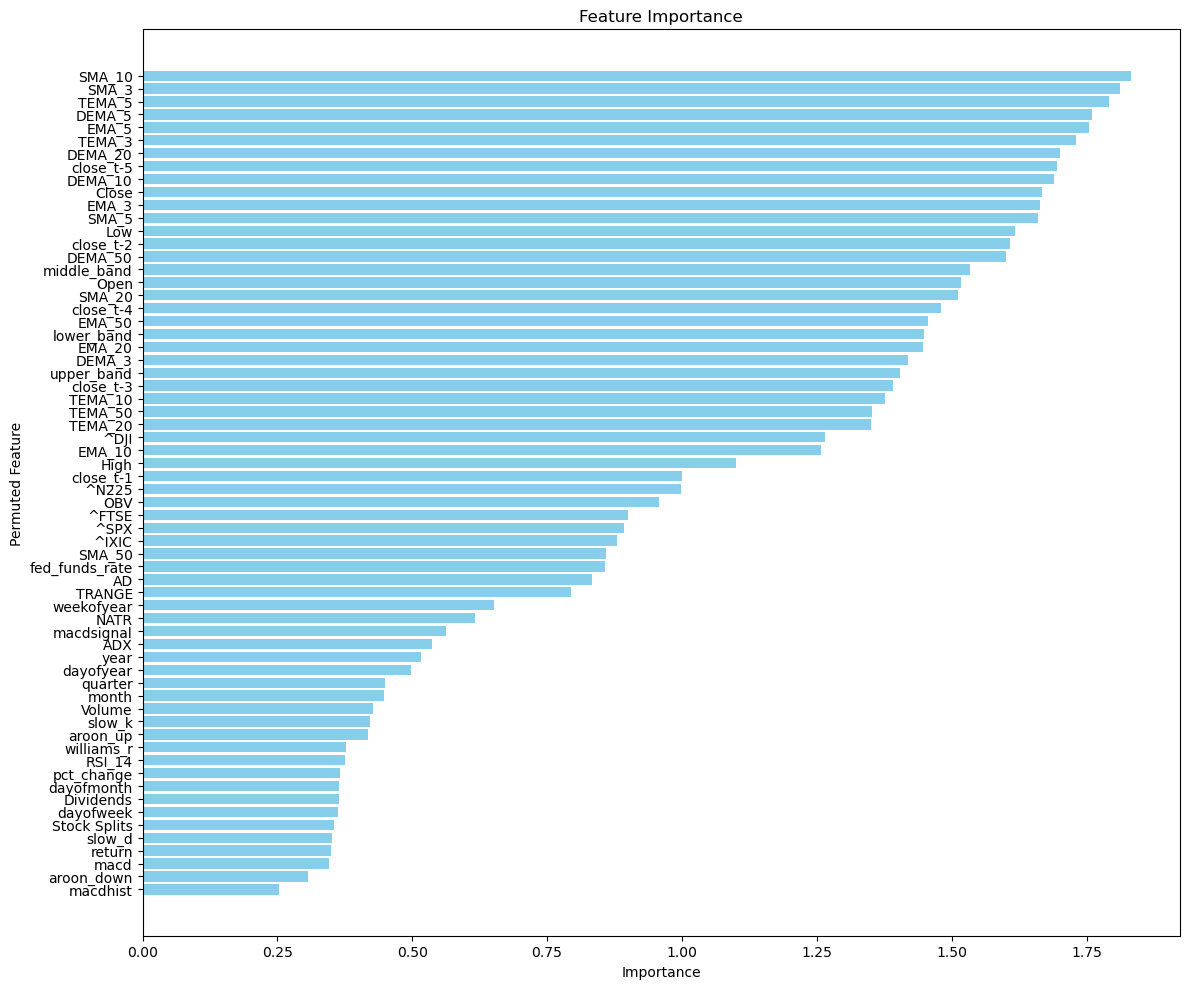

In [148]:
comb_scores = pi_scores_norm.add(mi_scores_norm, fill_value=0)
comb_scores = comb_scores.sort_values()
# Plotting
plt.figure(figsize=(12, 10))
plt.barh(comb_scores.index, comb_scores.values, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Permuted Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

NEXT STEPS: Generate feature sets
- Base (Close, High, Low, Open, Volume)
- All 
- Top 10 
- Top 30 
- Top 50

(PCA doesn't tell if your original features are good https://news.ycombinator.com/item?id=30876293, but NNs don't have problem with multicolinearity so fine...)

Pick lowest RMSE 

Automatic Hyperparameter Tuning

(ALSO EXTEND TIME HORIZON! Make LSTM output longer)


# Rejected Approaches

## Wrapper Methods

Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Select a model for feature ranking
model = RandomForestRegressor(n_estimators=100)

# RFE
selector = RFE(estimator=model, n_features_to_select=20, step=1)
selector = selector.fit(X, y)

# Selected Features
selected_features = selector.support_
selected_feature_names = X.columns[selected_features]
print("Selected features:", selected_feature_names.tolist())


KeyboardInterrupt: 

Sequential Feature Selection (SFS)

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Linear model for SFS
lr = LinearRegression()

# Forward SFS (set forward=True for forward selection)
sfs = SequentialFeatureSelector(lr, n_features_to_select=10, direction='forward')
sfs.fit(X, y)

# Selected Features
selected_features = sfs.get_support()
selected_feature_names = X.columns[selected_features]
print("Selected features:", selected_feature_names.tolist())

Selected features: ['Close', 'close_t-2', 'close_t-3', 'dayofweek', 'year', 'dayofmonth', 'aroon_down', 'williams_r', 'TRANGE', 'log_fed_funds_rate']


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Linear model for SFS
lr = LinearRegression()

# Forward SFS (set forward=True for forward selection)
sfs = SequentialFeatureSelector(lr, n_features_to_select=3, direction='backward')
sfs.fit(X, y)

# Selected Features
selected_features = sfs.get_support()
selected_feature_names = X.columns[selected_features]
print("Selected features:", selected_feature_names.tolist())

Selected features: ['Close', 'log_open', 'fed_funds_rate']


## Embedded Methods

LASSO (L1 Regularization)

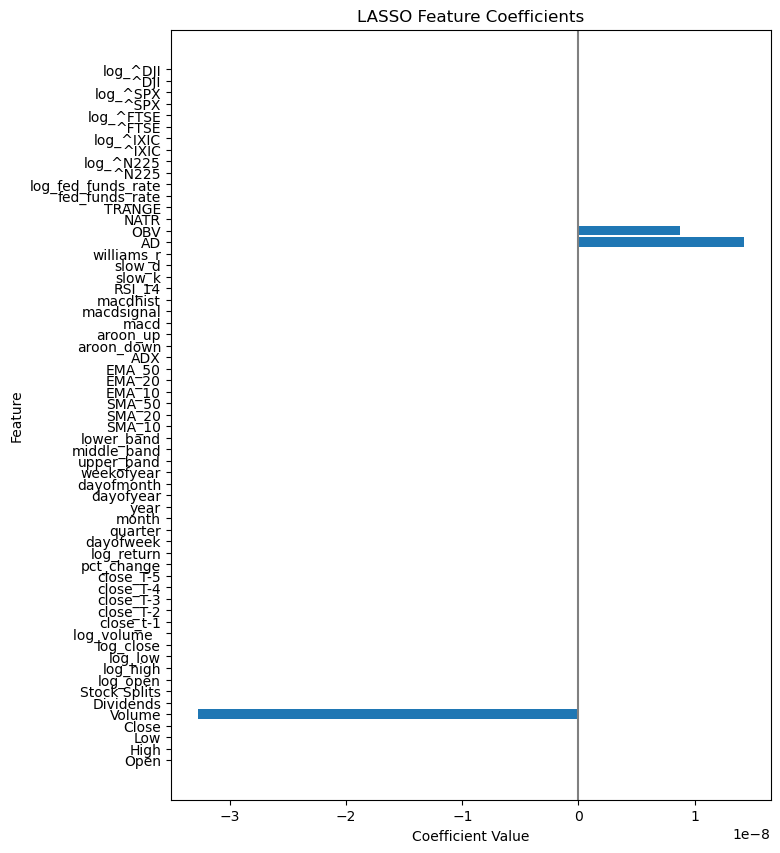

In [ ]:
from sklearn.linear_model import LassoCV
import numpy as np

# LASSO with cross-validation to find the best alpha (regularization strength)
lasso = LassoCV(random_state=42).fit(X, y)

# Plot
plt.figure(figsize=(10, 10))
plt.barh(range(X.shape[1]), lasso.coef_, align='center')
plt.yticks(np.arange(X.shape[1]), X.columns)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("LASSO Feature Coefficients")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.show()


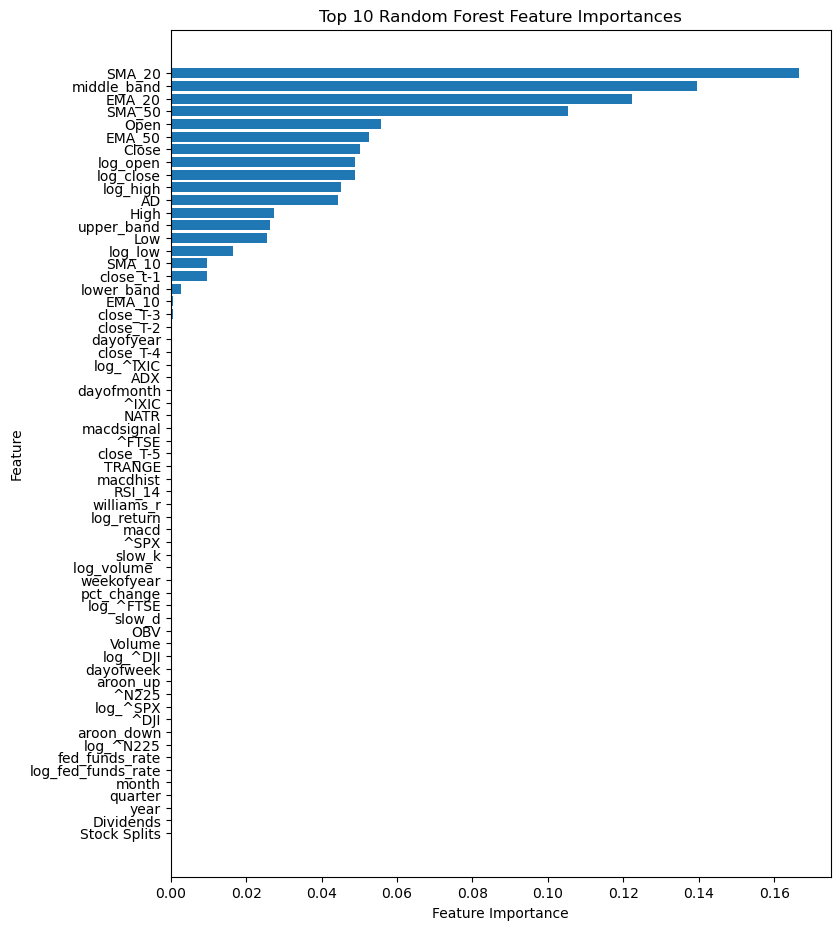

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# Random Forest for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)

# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top N features
N = len(X.columns)  # Number of top features to display
plt.figure(figsize=(11, 11))
plt.barh(range(N), importances[indices[:N]], align='center')
plt.yticks(np.arange(N), [X.columns[i] for i in indices[:N]])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Random Forest Feature Importances")
plt.subplots_adjust(left=0.3)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

In [ ]:
# Plot top N features
plt.figure(figsize=(10, 10))
plt.barh(range(N), importances[indices[:N]], align='center')
plt.yticks(np.arange(N), [X.columns[i] for i in indices[:N]])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Random Forest Feature Importances")
plt.subplots_adjust(left=0.3)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.xlim(0,0.0025)
plt.show()

NameError: name 'N' is not defined

<Figure size 1000x1000 with 0 Axes>

## Permutation Feature Importance (Column-Drop Variant)

In [ ]:
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", ".*Checkpoint directory.*exists and is not empty.")
warnings.filterwarnings("ignore", ".*The number of training batches (.*) is smaller")

torch.manual_seed(42)

perm_importances = []
for feature_to_drop in features:
    new_feature_set = [f for f in features if f != feature_to_drop]
    model = StockPricePredictor(new_feature_set, sequence_len, len(new_feature_set), hidden_dim, num_layers, output_dim, lr)
    data_module = StockDataModule("aapl", new_feature_set, sequence_len, batch_size)
    logger = TensorBoardLogger("tb_logs", name=f"lstm_pi_drop_{feature_to_drop}", default_hp_metric=False)
    checkpoint_callback = ModelCheckpoint(dirpath="models/", save_top_k=2, monitor="hp/rmse")
    trainer = Trainer(max_epochs=num_epochs, callbacks=[checkpoint_callback], logger=logger, enable_progress_bar=False, enable_model_summary=False)
    trainer.fit(model, datamodule=data_module)

    val_metrics = trainer.validate(datamodule=data_module, ckpt_path="best", verbose=False)
    perm_importances.append({
        "dropped_feature": feature_to_drop,
        "rmse": val_metrics[0]["hp/rmse"],
        "importance": val_metrics[0]["hp/rmse"] - base_rmse
    })
    print(f"{feature_to_drop}: {val_metrics[0]['hp/rmse'] - base_rmse}")
perm_importances


Open: -0.6198768615722656
High: -2.7218875885009766
Low: -1.363525390625
Close: -0.8266353607177734
Volume: -0.19973468780517578
Dividends: -0.4063596725463867
Stock Splits: 0.33273887634277344
close_t-1: -2.1524505615234375
close_t-2: -0.0051708221435546875
close_t-3: 2.136857032775879
close_t-4: -1.8818588256835938
close_t-5: -1.1553573608398438
pct_change: 1.5531063079833984
return: -1.0216188430786133
dayofweek: -0.11219978332519531
quarter: -0.026906967163085938
month: -2.866300582885742
year: -0.9714679718017578
dayofyear: -0.438201904296875
dayofmonth: -0.17662715911865234
weekofyear: -2.835394859313965
upper_band: -1.475031852722168
middle_band: -1.5739574432373047
lower_band: -1.3671636581420898
SMA_3: -1.2612180709838867
SMA_5: -0.5437421798706055
SMA_10: -1.5910024642944336
SMA_20: 1.5716371536254883
SMA_50: 0.30545711517333984
EMA_3: -2.9904356002807617
EMA_5: -0.11857223510742188
EMA_10: 0.4315004348754883
EMA_20: -1.8994951248168945
EMA_50: 1.8188304901123047
DEMA_3: -0.0

[{'dropped_feature': 'Open',
  'rmse': 13.407116889953613,
  'importance': -0.6198768615722656},
 {'dropped_feature': 'High',
  'rmse': 11.305106163024902,
  'importance': -2.7218875885009766},
 {'dropped_feature': 'Low',
  'rmse': 12.663468360900879,
  'importance': -1.363525390625},
 {'dropped_feature': 'Close',
  'rmse': 13.200358390808105,
  'importance': -0.8266353607177734},
 {'dropped_feature': 'Volume',
  'rmse': 13.827259063720703,
  'importance': -0.19973468780517578},
 {'dropped_feature': 'Dividends',
  'rmse': 13.620634078979492,
  'importance': -0.4063596725463867},
 {'dropped_feature': 'Stock Splits',
  'rmse': 14.359732627868652,
  'importance': 0.33273887634277344},
 {'dropped_feature': 'close_t-1',
  'rmse': 11.874543190002441,
  'importance': -2.1524505615234375},
 {'dropped_feature': 'close_t-2',
  'rmse': 14.021822929382324,
  'importance': -0.0051708221435546875},
 {'dropped_feature': 'close_t-3',
  'rmse': 16.163850784301758,
  'importance': 2.136857032775879},
 {

In [ ]:
df = pd.DataFrame(perm_importances).sort_values(by="importance", ascending=False).reset_index()
# Plotting
plt.figure(figsize=(12, 10))
plt.barh(df['dropped_feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Dropped Feature')
plt.title('Permutation Feature Importance (Column-Drop Variant)')
plt.tight_layout()
plt.show()

NameError: name 'perm_importances' is not defined